## Necessary imports

In [1]:
# Modules de base
import pandas as pd
import datetime
import haversine as hs
import matplotlib.cm as cm
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
%matplotlib inline
import folium
from folium import plugins

# Module relatif à Gurobi
from gurobipy import *

import warnings
warnings.filterwarnings("ignore")

## Useful functions

In [2]:
#Getting the data from the Instances files

def open_excel_employees(file):
    #open and reads the excel with the employees list
    df_employee=pd.read_excel(file,sheet_name="Employees")
    return df_employee

def open_excel_employees_unav(file):
    #open and reads the excel with the employees unavailabilities list
    df_employee_unav=pd.read_excel(file,sheet_name="Employees Unavailabilities")
    return df_employee_unav

def open_excel_tasks(file):
    #open and reads the excel with the task list
    df_tasks=pd.read_excel(file,sheet_name="Tasks")
    return df_tasks

def open_excel_tasks_unav(file):
    #open and reads the excel with the task unavailabilities list
    df_tasks_unav=pd.read_excel(file,sheet_name="Tasks Unavailabilities")
    return df_tasks_unav

def main(path):
    #returns the four dataframes
    employees=open_excel_employees(path)
    employees_unav=open_excel_employees_unav(path)
    tasks=open_excel_tasks(path)
    tasks_unav=open_excel_tasks_unav(path)
    return employees, employees_unav, tasks, tasks_unav

In [3]:
#See report for further explanation 

#We compute all times in minutes after midnight, since the tasks changes everyday
def convert_time_to_minute(dt):
    #converting a datetime string to minutes
    return dt.hour*60+dt.minute

def start_employees(df_employee):
    #time of the start of the work day for each employee
    return dict(zip(df_employee.EmployeeName, pd.to_datetime(df_employee.WorkingStartTime).apply(convert_time_to_minute)))

def end_employees(df_employee):
    #time of the end of the work day for each employe
    return dict(zip(df_employee.EmployeeName, pd.to_datetime(df_employee.WorkingEndTime).apply(convert_time_to_minute)))

def task_duration(df_tasks):
    #the duration per task vector
    return dict(zip(df_tasks.TaskId, df_tasks.TaskDuration))

def task_level(df_tasks):
    #the level per task vector
    return dict(zip(df_tasks.TaskId, df_tasks.Level))

def employee_level(df_employee):
    #the level of each employe vector
    return dict(zip(df_employee.EmployeeName, df_employee.Level))

def task_opening(df_tasks):
    #the start of each task vector
    return dict(zip(df_tasks.TaskId, pd.to_datetime(df_tasks.OpeningTime).apply(convert_time_to_minute)))

def task_closing(df_tasks):
    #the end of each task vector
    return dict(zip(df_tasks.TaskId, pd.to_datetime(df_tasks.ClosingTime).apply(convert_time_to_minute)))

def home_employee(df_employee):
    #the position (latitude, longitude) of each employee's house
    dic=dict()
    for agent in df_employee.EmployeeName.unique():
        l=dict()
        sub_df=df_employee[df_employee.EmployeeName==agent]
        l["Latitude"]=sub_df.Latitude.iloc[0]
        l["Longitude"]=sub_df.Longitude.iloc[0]
        dic[agent]=l
    return dic

In [4]:
#Dealing with unavailabilities

def position_unav(df_employees_unav):
    #the position of each unavailability per employee
    dic=dict()
    for agent in df_employees_unav.EmployeeName.unique():
        l=dict()
        sub_df=df_employees_unav[df_employees_unav.EmployeeName==agent]
        l["Latitude"]=sub_df.Latitude.tolist()
        l["Longitude"]=sub_df.Longitude.tolist()
        dic[agent]=l
    return dic

def start_unav_employee(df_employees, df_employees_unav):
    #the time starts of the unavailabilities per employee
    dic={}
    for agent in df_employees.EmployeeName.unique():
        l=[]
        sub_df=df_employees_unav[df_employees_unav.EmployeeName==agent]
        l=pd.to_datetime(sub_df.Start).apply(convert_time_to_minute).tolist()
        dic[agent]=l
    return dic

def unav_duration(df_employees, df_employees_unav):
    #the duration per unavailability per employee vector
    dic={}
    for agent in df_employees.EmployeeName.unique():
        l=[]
        sub_df=df_employees_unav[df_employees_unav.EmployeeName==agent]
        l= (pd.to_datetime(sub_df.End).apply(convert_time_to_minute)-pd.to_datetime(sub_df.Start).apply(convert_time_to_minute)).tolist()
        dic[agent]=l
    return dic

def avail_task(df_tasks, df_tasks_unav):
    #the time periods on which each task is available (dic of lists of lists)
    dic={}
    for row in df_tasks.itertuples():
        if row.TaskId not in list(df_tasks_unav['TaskId']):
            dic[row.TaskId]=[[convert_time_to_minute(pd.to_datetime(row.OpeningTime)), convert_time_to_minute(pd.to_datetime(row.ClosingTime))]]
        else:
            unav=df_tasks_unav[df_tasks_unav['TaskId']==row.TaskId].sort_values(by='Start')
            l=[[convert_time_to_minute(pd.to_datetime(row.OpeningTime))]]
            for r in unav.itertuples():
                if r.Start==row.OpeningTime:
                    l.pop()
                    l.append([convert_time_to_minute(pd.to_datetime(r.End))])
                else:   
                    l[-1].append(convert_time_to_minute(pd.to_datetime(r.Start)))
                    l.append([convert_time_to_minute(pd.to_datetime(r.End))])
            if l[-1][0]==convert_time_to_minute(pd.to_datetime(row.ClosingTime)):
                l.pop()
            else:
                l[-1].append(convert_time_to_minute(pd.to_datetime(row.ClosingTime)))
            dic[row.TaskId]=l
    return dic

In [5]:
def list_nodes(employees, tasks, POS_in):
    #This function gives the list of tasks and adds a departure and arrival for all agents
    df3=employees[["EmployeeName",'Latitude', 'Longitude']]
    df3.rename(columns={"EmployeeName": "TaskId"},inplace=True)
    df3.set_index("TaskId", inplace=True)
    
    
    for agent in POS_in:
        for i in range(len(POS_in[agent]['Latitude'])):
            d={'Latitude': POS_in[agent]['Latitude'][i], 'Longitude': POS_in[agent]['Longitude'][i]}
            l=list()
            l.append( agent+"_"+str(i))
            sub_df = pd.DataFrame(data=d, index= l)
            df3= pd.concat([df3, sub_df])
    
    df4=tasks[["TaskId",'Latitude', 'Longitude']]
    df4.set_index("TaskId", inplace=True)
    list_coords = pd.concat([df3, df4])
    return list_coords


def list_tasks_and_unav(tasks, POS_in):
    #This function gives the list of tasks and unavailabilities
    for agent in POS_in:
        for i in range(len(POS_in[agent]['Latitude'])):
            d={'Latitude': POS_in[agent]['Latitude'][i], 'Longitude': POS_in[agent]['Longitude'][i]}
            l=list()
            l.append( agent+"_"+str(i))
            sub_df = pd.DataFrame(data=d, index= l)
    
    df4=tasks[["TaskId",'Latitude', 'Longitude']]
    df4.set_index("TaskId", inplace=True)
    list_coords = pd.concat([sub_df, df4])
    return list_coords

def compute_distance(employees, tasks, POS_in):
    #this function computes the euclidian distance between each node, and divides by 50km/h to keep a distance in time
    C= dict()
    list_coord = list_nodes(employees, tasks, POS_in)
    
    lat=dict(list_coord.Latitude)
    long=dict(list_coord.Longitude)
    
    for key1 in lat:
        for key2 in lat:
            lat1, long1 = lat[key1], long[key1]
            lat2, long2 = lat[key2], long[key2]
            C[key1, key2] = hs.haversine([lat1, long1], [lat2, long2])*6/5
    #It returns a dictionnary        
    return C

The following cells are to be executed each time you want to test the model on new Instances. 

## Getting the data

In [6]:
#Ask user to chose for instance

print("Hello !!!\n")
print("The different data sets for this second version are :\n")
print("1 - Australia\n")
print("2 - Austria\n")
print("3 - Poland\n")
print("4 - Bordeaux\n")
print("5 - Spain\n")



set_chosen = int(input("Enter a number between 1 and 5\n"))
if set_chosen<1 or set_chosen>5:
    print("error no set available")
    

sets = { 1: "Australia", 2: "Austria", 3: "Poland", 4: "Bordeaux", 5 : "Spain"}

choice= "../data/InstancesV2/Instance" +sets[set_chosen]+"V2.xlsx"
employees,  employees_unav, tasks, tasks_unav = main(choice)

employees.columns = ['EmployeeName', 'Latitude', 'Longitude', 'Skill', 'Level', 'WorkingStartTime', 'WorkingEndTime']

display(employees.head(5))
display(tasks.head(10))
display(tasks_unav)
display(employees_unav)


Hello !!!

The different data sets for this second version are :

1 - Australia

2 - Austria

3 - Poland

4 - Bordeaux

5 - Spain



,EmployeeName,Latitude,Longitude,Skill,Level,WorkingStartTime,WorkingEndTime
0,John,-37.313914,145.735695,Plumbing,2,8:00am,6:00pm
1,Sam,-36.644417,146.590571,Plumbing,2,8:00am,6:00pm
2,David,-36.668908,146.638506,Plumbing,1,8:00am,6:00pm


,TaskId,Latitude,Longitude,TaskDuration,Skill,Level,OpeningTime,ClosingTime
0,T1,-36.102979,145.494369,40,Plumbing,1,8:00am,6:00pm
1,T2,-36.076081,145.819361,40,Plumbing,2,8:00am,6:00pm
2,T3,-36.518091,146.161826,40,Plumbing,1,8:00am,6:00pm
3,T4,-36.921593,145.219754,40,Plumbing,1,8:00am,6:00pm
4,T5,-36.885474,146.414399,40,Plumbing,2,8:00am,6:00pm
5,T6,-35.651866,146.436168,40,Plumbing,2,8:00am,6:00pm
6,T7,-35.595599,146.397259,40,Plumbing,2,8:00am,6:00pm
7,T8,-36.738221,144.598415,40,Plumbing,1,8:00am,6:00pm
8,T9,-36.987485,144.769250,40,Plumbing,1,8:00am,6:00pm
9,T10,-35.792319,146.958308,40,Plumbing,1,8:00am,6:00pm


,TaskId,Start,End
0,T1,10:00am,12:00pm
1,T4,3:00pm,4:00pm
2,T7,9:00am,12:00pm
3,T10,2:00pm,4:00pm
4,T13,8:00am,9:00am
5,T15,2:00pm,5:00pm


,EmployeeName,Latitude,Longitude,Start,End
0,Sam,-36.145489,144.745313,10:30am,11:30am


## Building our data structures

In [7]:
#Applying all our functions to our dataframes
POS=home_employee(employees)
POS_in=position_unav(employees_unav)

M=task_level(tasks)
Q=employee_level(employees)

D=start_employees(employees)
F=end_employees(employees)
Du=start_unav_employee(employees, employees_unav)
Su=unav_duration(employees, employees_unav)


S=task_duration(tasks)

for agent in Q:
    duration=Su[agent]
    for r in range(len(Du[agent])):
        S[str(agent)+'_'+str(r)]=duration[r]
        
O=avail_task(tasks, tasks_unav)

for agent in Q:
    start=Du[agent]
    duration=Su[agent]
    for r in range(len(Du[agent])):
        O[str(agent)+'_'+str(r)]=[[start[r], start[r]+duration[r]]]

print("POS =", POS,"\n")
print("POS_in =", POS_in,"\n")

print("M =", M,"\n")
print("Q =", Q,"\n")

print("D =", D,"\n")
print("F =", F,"\n")
print("Du=", Du,"\n")
print("Su=", Su,"\n")

print("S =", S,"\n")
print("O =", O,"\n")

POS = {'John': {'Latitude': -37.31391370000001, 'Longitude': 145.7356949}, 'Sam': {'Latitude': -36.644416799999995, 'Longitude': 146.5905705}, 'David': {'Latitude': -36.6689076, 'Longitude': 146.6385064}} 

POS_in = {'Sam': {'Latitude': [-36.14548949091688], 'Longitude': [144.74531255446811]}} 

M = {'T1': 1, 'T2': 2, 'T3': 1, 'T4': 1, 'T5': 2, 'T6': 2, 'T7': 2, 'T8': 1, 'T9': 1, 'T10': 1, 'T11': 1, 'T12': 1, 'T13': 1, 'T14': 1, 'T15': 1, 'T16': 1} 

Q = {'John': 2, 'Sam': 2, 'David': 1} 

D = {'John': 480, 'Sam': 480, 'David': 480} 

F = {'John': 1080, 'Sam': 1080, 'David': 1080} 

Du= {'John': [], 'Sam': [630], 'David': []} 

Su= {'John': [], 'Sam': [60], 'David': []} 

S = {'T1': 40, 'T2': 40, 'T3': 40, 'T4': 40, 'T5': 40, 'T6': 40, 'T7': 40, 'T8': 40, 'T9': 40, 'T10': 40, 'T11': 40, 'T12': 40, 'T13': 40, 'T14': 40, 'T15': 40, 'T16': 40, 'Sam_0': 60} 

O = {'T1': [[480, 600], [720, 1080]], 'T2': [[480, 1080]], 'T3': [[480, 1080]], 'T4': [[480, 900], [960, 1080]], 'T5': [[480, 1080]]

In [8]:
C=compute_distance(employees, tasks,POS_in)

all_unav = {}
for agent in Q :
    l = []
    for r in range(len(Du[agent])):
        l.append(str(agent)+'_'+str(r))
    all_unav[agent]= l

all_tasks_and_unav = [task for task in M]
for agent in Q :
    for r in range(len(Du[agent])):
        all_tasks_and_unav.append(str(agent)+'_'+str(r))

tasks_and_homes_and_unav = {}
for agent in Q :
    l = [task for task in M]
    l.append(agent)
    for r in range(len(Du[agent])):
        l.append(str(agent)+'_'+str(r))
    tasks_and_homes_and_unav[agent]= l

print(tasks_and_homes_and_unav)

{'John': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'John'], 'Sam': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'Sam', 'Sam_0'], 'David': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'David']}


## Optimizing with Gurobi

In [9]:
# -- Initializing our model --
# m : Model
m = Model("PL-Model1")
m.params.TimeLimit = 3600

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27
Set parameter TimeLimit to value 3600


In [10]:
# -- Adding binary and continous variables  --
# Xijk : Binary variables : path from node i to j for employe k
X = {(task1, task2, agent) : m.addVar(vtype = GRB.BINARY, name = f'X{task1}_{task2}_{agent}') for agent in Q for task1 in tasks_and_homes_and_unav[agent] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2}

# Wi: Arrival time at node i
#We have chosen to compute arrival times in minutes, compared to midnight
W = {node : m.addVar(vtype = GRB.INTEGER, name = f'W{node}') for node in all_tasks_and_unav}

#Pk: Start of lunch break for employe k
P={agent: m.addVar(vtype = GRB.INTEGER, name = f'P_{agent}',lb=720, ub=780) for agent in Q}

#Beta : adjustment variables for the opening hours of the spots: = 1 if the spot is done in the interval r
Beta={}
for node in all_tasks_and_unav:
    for r in range(len(O[node])):
        Beta[(node, r)]=m.addVar(vtype = GRB.BINARY, name =f'Beta{node}{r}')
        
#Gamma: adjustment variable for lunch breaks
Gamma = {(node, agent) : m.addVar(vtype =GRB.BINARY , name = f'Gamma{node}{agent}') for node in all_tasks_and_unav for agent in Q}

In [11]:
# -- Adding the constraints --

#Flow constraint
constr_flow = dict()
for agent in Q:
    for task1 in tasks_and_homes_and_unav[agent]:
        constr_flow[task1,agent]=m.addConstr(quicksum([X[(task1, task2 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) == quicksum([X[(task2, task1 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]), name = f'flow_{task1}_{agent}')

#Task assignment constraints
constr_assign = dict()
for task1 in M:
    constr_assign[task1]=m.addConstr(quicksum([quicksum([X[(task1, task2 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q]) <=1, name = f'assign_{task1}_{agent}')

constr_assign_h1=dict()
for agent in Q:
    constr_assign_h1[agent]=m.addConstr(quicksum([X[(agent, task1 ,agent)] for task1 in tasks_and_homes_and_unav[agent] if task1!=agent]) <=1, name = f'assign_h1_{agent}')

constr_assign_u=dict()
for agent in Q:
    for unav in all_unav[agent]:
        constr_assign_u[unav, agent]=m.addConstr(quicksum([X[(task1, unav, agent)] for task1 in tasks_and_homes_and_unav[agent] if task1!=unav]) ==1, name = f'assign_u_{unav}_{agent}')

#Competency constraint 
constr_compet= dict()
for task1 in M:
    constr_compet[task1]=m.addConstr(quicksum([quicksum([X[(task2, task1 ,agent)]*M[task1] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q]) <= quicksum([quicksum([X[(task2, task1 ,agent)]*Q[agent] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q]), name = f'compet{task1}')   

H = 10000

#Working hours constraint
constr_working_hours1 = dict()
constr_working_hours2 = dict()

for agent in Q:
    for task1 in M:
        constr_working_hours1[task1,agent]=m.addConstr(D[agent]+C[agent,task1]-W[task1] <= H*(1-quicksum([X[(task1, task2 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2])), name = f'hour1{task1}_{agent}')
        constr_working_hours2[task1,agent]=m.addConstr(W[task1]- F[agent]+ S[task1]+C[task1,agent] <= H*(1-quicksum([X[(task1, task2 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2 ])), name = f'hour2{task1}_{agent}')    

#Unavailabilities employees hours constraint
constr_working_hours3 = dict()

for agent in Q:
    for r in range(len(Du[agent])):
        constr_working_hours3[agent, r]=m.addConstr(quicksum([X[(task2, str(agent)+"_"+str(r),agent)] for task2 in tasks_and_homes_and_unav[agent] if task2!=str(agent)+"_"+str(r)]) == 1, name = f'hour3_{agent}_{r}')
        
    
#Lunch break constraints 
constr_lunch_1 = dict()
constr_lunch_2 = dict()
constr_lunch_3 = dict()
constr_lunch_4 = dict()


for task1 in all_tasks_and_unav:
    constr_lunch_1[task1]=m.addConstr(quicksum([Gamma[task1,agent] for agent in Q])<=1, name=f'lunch1{task1}')
        

for agent in Q:
    for task1 in all_tasks_and_unav:
        if task1 in M or task1 in all_unav[agent]:
            constr_lunch_2[task1, agent]=m.addConstr(Gamma[task1,agent]<=quicksum([X[(task1,task2,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]), name=f'lunch2{task1}_{agent}')
            constr_lunch_3[task1,agent]=m.addConstr(W[task1]-P[agent]+S[task1]<=H*(2-Gamma[task1,agent]-quicksum([X[(task1,task2,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2])), name=f'lunch3{task1}_{agent}')
            constr_lunch_4[task1, agent]=m.addConstr(60+P[agent]-W[task1]<=H*(1+Gamma[task1,agent]-quicksum([X[(task1, task2 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2])), name=f'lunch4{task1}_{agent}')


#Task duration constraint
constr_dur= dict()
for task1 in all_tasks_and_unav:   
    for task2 in all_tasks_and_unav:
        if task1!=task2:
            constr_dur[task1, task2, agent]= m.addConstr(W[task1]+S[task1]+C[task1,task2]+60*quicksum([Gamma[task1,agent] for agent in Q])-W[task2]<= H*(1-quicksum([X[(task1, task2 ,agent)] for agent in Q if (task1 in M) or (task1 in all_unav[agent]) if(task2 in M) or (task2 in all_unav[agent]) ])), name = f'dur{task1}_{task2}') 

#Unavailabilities tasks constraint 
constr_open1 = dict()
constr_open2 = dict()
constr_open3 = dict()
for task1 in all_tasks_and_unav:
    constr_open3[task1] = m.addConstr(quicksum([quicksum([X[(task2, task1 ,agent)] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q if (task1 in M) or (task1 in all_unav[agent])])==quicksum([Beta[(task1,r)] for r in range(len(O[task1]))]), name = f'open3{task1}')
    for r in range(len(O[task1])):    
        constr_open1[task1, r] = m.addConstr(O[task1][r][0]-W[task1]<=(1-Beta[(task1,r)])*H , name = f'open1{task1}_{r}')
        constr_open2[task1, r] = m.addConstr(-O[task1][r][1]+W[task1]+S[task1]<=(1-Beta[(task1,r)])*H , name = f'open2{task1}_{r}')


In [12]:
# -- Adding the objective functions -- 
obj1_dur= quicksum([quicksum([X[(task1, task2 ,agent)]*S[task1] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q for task1 in M])
obj2_dist= quicksum([quicksum([X[(task1, task2 ,agent)]*C[task1,task2] for task1 in tasks_and_homes_and_unav[agent] for task2 in tasks_and_homes_and_unav[agent] if task1!=task2]) for agent in Q])

m.setObjective(0.8*obj1_dur-0.08*obj2_dist, GRB.MAXIMIZE)

# -- Choice of a minimalist display setting --
m.params.outputflag = 1

# -- Updating the model --
m.update()

# -- Text mode display of the PL --
#print(m.display())

In [13]:
# -- Resolution --
m.optimize()

print(m, "\n")


# -- Solution Display --
print("L'affectation optimale des trajets se fait comme suit:")
for task in all_tasks_and_unav:
    print("Heure d'arrivée à la tâche ", task, " :", W[task].x, " min")
    
print("Affectation des heures de pause pour les agents: ")
for agent in Q:
    print("Heure de pause de l'agent ", agent, " :", P[agent].x, " min")

for agent in Q: 
    for task1 in tasks_and_homes_and_unav[agent]:
        for task2 in tasks_and_homes_and_unav[agent]:
            if task1!=task2:
                if X[(task1, task2 ,agent)].x !=0:
                    print("trajet de ", task1, "à ", task2, "par l'agent ", agent," :", X[(task1, task2 ,agent)].x)
                    
                    
print("Final MIP gap value: %f" % m.MIPGap)                   
            
                    
                    

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 682 rows, 943 columns and 10511 nonzeros
Model fingerprint: 0x5304874d
Variable types: 0 continuous, 943 integer (923 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e-02, 3e+01]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 2e+04]
Presolve removed 114 rows and 600 columns
Presolve time: 0.10s
Presolved: 568 rows, 343 columns, 4002 nonzeros
Variable types: 0 continuous, 343 integer (324 binary)
Found heuristic solution: objective -2.2534924

Root relaxation: objective 3.777219e+02, 152 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  377.72189    0   33   -2.25349  377.72189      -     -    0s
H    0     0               

## Results and analysis

In [15]:
#Output formatting
dic={}
lunch={}
name="./Solutions/Text/Solution"+sets[set_chosen]+"V2"+"By2.txt"
f = open(name, "w")
f.write("taskId;performed;employeeName;startTime;\n")
for agent in Q:
    dic[agent]={}
for task1 in M:
    best_solution=0
    best_txt=""
    for agent in Q: 
        for task2 in tasks_and_homes_and_unav[agent]: 
        #we consider that a task is done by the agent if he goes from this task to another or to his house
            if task1!=task2:
                if (X[(task1, task2 ,agent)].x !=0):
                    best_solution=int(X[(task1, task2 ,agent)].x)
                    best_txt= task1+";"+ str(int(X[(task1, task2 ,agent)].x))+";"+str(agent)  +";"+str(int(W[task1].x))+"\n"
                    dic[agent][task1]=int(W[task1].x)
                    break
    if best_solution==1:
        f.write(best_txt)
    else: 
        f.write(task1+";0;;;\n")
f.write("\n")
f.write("employeeName;lunchBreakStartTime;\n")
for agent in Q: 
    f.write(agent+";"+str(P[agent].x)+";"+"\n")
    lunch[agent]=int(P[agent].x)
    for unav in all_unav[agent]:
        dic[agent][unav]=int(W[unav].x)
f.close()


print(dic)

{'John': {'T4': 556, 'T8': 780, 'T9': 858}, 'Sam': {'T1': 831, 'T2': 927, 'Sam_0': 630}, 'David': {'T3': 832, 'T10': 602}}


In [16]:
#Compute for the set chosen the number of constraints (see report)
def constraints(tasks, employees, unav, unav_t):
    return employees+4*tasks+2*unav+4*employees*tasks+ 2*employees*unav+ (unav+tasks)**2+ 2*unav_t*(tasks+unav)
print("Le nombre de contraintes pour "+ sets[set_chosen]+" est :" , constraints(len(M), len(Q), employees_unav.shape[0], tasks_unav.shape[0]))

Le nombre de contraintes pour Australia est : 760


In [17]:
#To produce the path of the employees on a map
center = [employees.loc[0,'Latitude'], employees.loc[0,'Longitude']] #centre de la carte
e=employees.set_index('EmployeeName')
t=tasks.set_index('TaskId')

Map = folium.Map(location=center, zoom_start=8)

for index, lat, lon in t[['Latitude', 'Longitude']].itertuples():
    folium.Marker(location=[lat,lon], popup=index, icon=folium.Icon(color="blue", icon="glyphicon glyphicon-wrench") ).add_to(Map) 

for index, lat, lon, name in employees_unav[['Latitude', 'Longitude', 'EmployeeName']].itertuples():
    folium.Marker(location=[lat,lon], popup='Indispo_'+name+'_'+str(index), icon=folium.Icon(color="purple", icon="glyphicon glyphicon-ban-circle") ).add_to(Map) 

for agent in POS_in :
    for i in range(len(POS_in[agent]['Latitude'])):
        d={'Latitude': POS_in[agent]['Latitude'][i], 'Longitude': POS_in[agent]['Longitude'][i]}
        l=list()
        l.append( agent+"_"+str(i))
        sub_df = pd.DataFrame(data=d, index= l)
        t= pd.concat([t, sub_df])

lgd_txt = '<span style="color: {col};">{txt}</span>'    #html pour l'affichage de la légende
   
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
count=-1
for agent in Q:
    count+=1
    color=colors[count]
    feature_group = folium.FeatureGroup(name= lgd_txt.format( txt= agent, col= color)) #legend
    dic_of_tasks=dic[agent]
    dic_t=sorted(dic_of_tasks, key=dic_of_tasks.get)
    coordinates_e = [e.loc[agent,'Latitude'], e.loc[agent,'Longitude']]
    folium.Marker(location=coordinates_e, popup='Maison_'+str(agent), icon=folium.Icon(color='red', icon="home")).add_to(feature_group) #lieu de sa maison
    pl= folium.PolyLine([coordinates_e]+[[t.loc[dic_t[i],'Latitude'], t.loc[dic_t[i],'Longitude']] for i in range(len(dic_t))]+[coordinates_e], color=color)
    pl.add_to(feature_group)
    '''folium.plugins.AntPath([coordinates_e]+[[t.loc[dic_t[i],'Latitude'], t.loc[dic_t[i],'Longitude']] for i in range(len(dic_t))]+[coordinates_e], {
  "delay": 400,
  "dashArray": [
    10,
    20
  ],
  "weight": 5,
  "color": color,
  "pulseColor": color,
  "paused": False,
  "reverse": False,
        "delay":2000
} ).add_to(feature_group)'''
    feature_group.add_to(Map)

folium.LayerControl().add_to(Map) 
Map.save('Solutions/Map/map_'+sets[set_chosen]+'V2.html')
Map

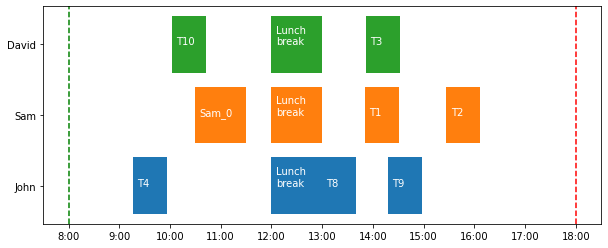

In [18]:
#To produce the visual timetable in png format
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
data = []
agents= [agent for agent in Q]
for agent in Q:
    dic_of_tasks=dic[agent]
    for task, time in dic_of_tasks.items():
        data.append((time, time+S[task], agent, task))
    data.append((lunch[agent], lunch[agent]+60, agent, 'Lunch \nbreak'))
        
cats = {agents[i]:i for i in range(len(agents))}
colormapping = {agents[i]:"C"+str(i) for i in range(len(agents))}

verts = {agents[i]:[]for i in range(len(agents))}
colors = {agents[i]:[]for i in range(len(agents))}
for d in data:
    v =  [(d[0], cats[d[2]]-.4),
          (d[0], cats[d[2]]+.4),
          (d[1], cats[d[2]]+.4),
          (d[1], cats[d[2]]-.4),
          (d[0], cats[d[2]]-.4)]
    verts[d[2]].append(v)
    colors[d[2]].append(colormapping[d[2]])
    ax.annotate(d[3], (d[0]+5, cats[d[2]]), color='w')

for cat in verts.keys():
    bars = PolyCollection(verts[cat], facecolors=colors[cat])
    ax.add_collection(bars)
    
ax.set_yticks([i for i in range(len(agents))])
ax.set_yticklabels(agents)
ax.set_xticks([i for i in range(480,1140, 60)])
ax.set_xticklabels([str(datetime.timedelta(minutes=i))[:-3] for i in range(480,1140, 60)])

ax.axvline(x = 480, color = "green", linestyle='--', label = "Start of the day") 
ax.axvline(x = 1080, color = "red", linestyle='--', label = "End of the day") 
ax.autoscale()
plt.savefig('Solutions/Timetable/timetable_'+sets[set_chosen]+'V2.png', transparent=True)